In [26]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys

cwd = Path.cwd()

# 이 노트북이 notebooks 폴더 안에 있다고 가정
if cwd.name == "notebooks":
    PROJECT_ROOT = cwd.parent
    NOTEBOOK_DIR = cwd
else:
    PROJECT_ROOT = cwd
    NOTEBOOK_DIR = PROJECT_ROOT / "notebooks"

print("NOTEBOOK_DIR:", NOTEBOOK_DIR)
print("PROJECT_ROOT:", PROJECT_ROOT)

# src 임포트 위해 프로젝트 루트 추가
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
NOTEBOOK_DIR: /Users/gy/projects/trading-project/notebooks
PROJECT_ROOT: /Users/gy/projects/trading-project


In [27]:
from src.models.har_rv import (
    HARConfig,
    load_usdjpy_indicators,
    fit_log_har_for_horizons,
    grid_search_log_har_sml
)

data_path = PROJECT_ROOT / "data_raw" / "usdjpym5_indicators_0529-1204.csv"
print("DATA PATH:", data_path)

df_raw = load_usdjpy_indicators(data_path)
df_raw.head()



DATA PATH: /Users/gy/projects/trading-project/data_raw/usdjpym5_indicators_0529-1204.csv


,Date,Time,Open,High,Low,Close,TickVolume,bbpb_20,bbpb_4,bbw_20,bbw_4,dp_14,Signal,Buy,Sell,OAN,XMG,Average
timestamp,,,,,,,,,,,,,,,,,,
2025-05-29 09:00:00,2025.05.29,09:00,144.886,145.003,144.877,144.978,457,1.255560,0.704077,0.162469,0.091332,0.106287,43.23,96.10,3.90,63.02,26.0,48.711429
2025-05-29 09:05:00,2025.05.29,09:05,144.977,145.187,144.974,145.165,520,1.379438,0.707715,0.270177,0.282427,0.215391,43.23,96.10,3.90,63.02,26.0,48.711429
2025-05-29 09:10:00,2025.05.29,09:10,145.165,145.343,145.164,145.322,838,1.314308,0.699726,0.400501,0.678662,0.298849,43.23,96.10,3.90,62.04,27.0,48.612857
2025-05-29 09:15:00,2025.05.29,09:15,145.322,145.457,145.319,145.370,913,1.172445,0.673778,0.502236,0.930076,0.303447,43.23,96.10,3.90,62.04,27.0,48.612857
2025-05-29 09:20:00,2025.05.29,09:20,145.370,145.473,145.359,145.468,703,1.127976,0.631375,0.605851,0.846577,0.338328,42.42,98.31,1.69,62.04,27.0,48.484286


In [11]:
horizons = [1, 3, 6, 12]

results = fit_log_har_for_horizons(
    df_raw,
    horizons=horizons,
    S=12,     # 1시간
    M=48,     # 4시간
    L=288,    # 24시간
    price_col="Close",
    eps=1e-12,
    train_ratio=0.8,
)

results.keys()


dict_keys([1, 3, 6, 12])

In [12]:
import pandas as pd

rows = []
for H in sorted(results.keys()):
    m = results[H]["metrics"]
    rows.append(
        {
            "H": H,
            "R2_train": m["R2_train"],
            "R2_adj_train": m["R2_adj_train"],
            "MSE_test_log": m["MSE_test_log"],
            "MAE_test_log": m["MAE_test_log"],
            "MSE_test_level": m["MSE_test_level"],
            "MAE_test_level": m["MAE_test_level"],
        }
    )

summary_df = pd.DataFrame(rows).set_index("H").sort_index()
summary_df



,R2_train,R2_adj_train,MSE_test_log,MAE_test_log,MSE_test_level,MAE_test_level
H,,,,,,
1,0.063604,0.063513,6.157928,1.843365,1.810000e-13,6.689627e-08
3,0.054719,0.054628,6.221555,1.854979,1.811697e-13,6.711469e-08
6,0.044251,0.044158,6.296593,1.865923,1.813458e-13,6.733228e-08
12,0.032026,0.031932,6.425730,1.885494,1.815571e-13,6.769250e-08


In [15]:
import pandas as pd

coef_rows = []
pval_rows = []

for H in sorted(results.keys()):
    res_H = results[H]["model"]
    
    row_coef = {"H": H}
    row_pval = {"H": H}
    
    for name, val in res_H.params.items():
        row_coef[name] = val
        row_pval[name] = res_H.pvalues[name]
    
    coef_rows.append(row_coef)
    pval_rows.append(row_pval)

coef_df = pd.DataFrame(coef_rows).set_index("H").sort_index()
pval_df = pd.DataFrame(pval_rows).set_index("H").sort_index()

print("=== 회귀 계수 (params) ===")
display(coef_df)

print("\n=== p-value ===")
display(pval_df)

# 필요하면 개별 H의 풀 summary도 이렇게 볼 수 있음:
# for H in sorted(results.keys()):
#     print(f"\n\n==== H = {H} ====")
#     print(results[H]['model'].summary())



=== 회귀 계수 (params) ===


,const,log_rv_s,log_rv_m,log_rv_l
H,,,,
1,-3.963262,0.527241,0.034935,0.218811
3,-4.411862,0.497811,-0.006387,0.264784
6,-4.995227,0.458061,-0.061225,0.327149
12,-5.749842,0.399200,-0.139015,0.422112



=== p-value ===


,const,log_rv_s,log_rv_m,log_rv_l
H,,,,
1,2.236400e-10,1.391049e-223,1.599208e-01,2.132708e-08
3,2.091425e-12,4.702702e-198,7.981705e-01,1.532983e-11
6,2.515928e-15,1.437489e-166,1.478009e-02,1.172763e-16
12,1.438033e-19,8.418046e-126,3.817704e-08,2.409775e-26


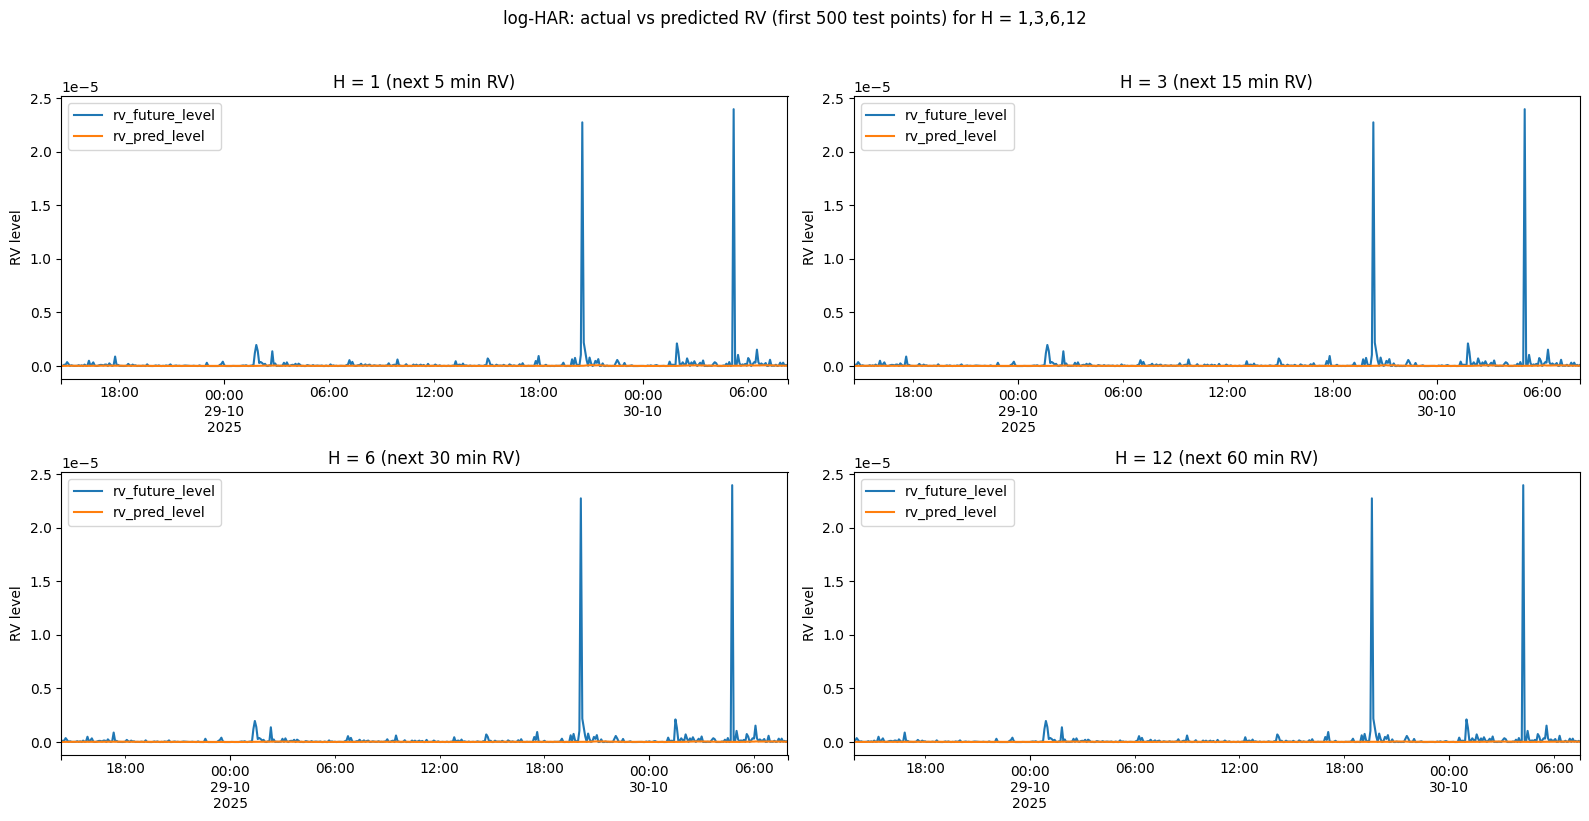

In [16]:
import numpy as np
import matplotlib.pyplot as plt

N = 500  # 각 H별 테스트 구간 처음 N개만 보기 (너가 원하는 길이로 조정 가능)

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False)

for ax, H in zip(axes.ravel(), sorted(results.keys())):
    res_H = results[H]
    
    df_har = res_H["df_har"]
    split_idx = res_H["split_idx"]
    
    # 테스트 구간
    df_eval = df_har.iloc[split_idx:].copy()
    
    # 실제/예측 (level 스케일)
    df_eval["rv_future_level"] = np.exp(df_eval["log_rv_future"])
    df_eval["rv_pred_level"] = res_H["y_pred_test_level"].values
    
    df_eval_plot = df_eval[["rv_future_level", "rv_pred_level"]].iloc[:N]
    df_eval_plot.plot(ax=ax)
    
    ax.set_title(f"H = {H} (next {H*5} min RV)")
    ax.set_xlabel("")
    ax.set_ylabel("RV level")

fig.suptitle(
    "log-HAR: actual vs predicted RV (first 500 test points) for H = 1,3,6,12",
    y=1.02,
)
plt.tight_layout()
plt.show()



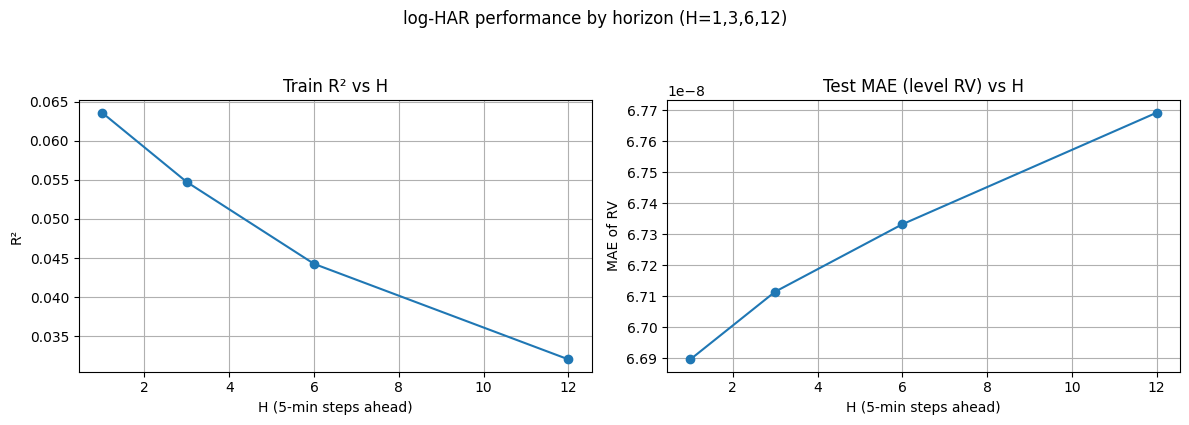

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1) R² (train) vs H
summary_df["R2_train"].plot(marker="o", ax=axes[0])
axes[0].set_title("Train R² vs H")
axes[0].set_xlabel("H (5-min steps ahead)")
axes[0].set_ylabel("R²")
axes[0].grid(True)

# 2) Test MAE(level) vs H
summary_df["MAE_test_level"].plot(marker="o", ax=axes[1])
axes[1].set_title("Test MAE (level RV) vs H")
axes[1].set_xlabel("H (5-min steps ahead)")
axes[1].set_ylabel("MAE of RV")
axes[1].grid(True)

fig.suptitle("log-HAR performance by horizon (H=1,3,6,12)", y=1.05)
plt.tight_layout()
plt.show()


In [30]:
# S,M,L 후보 정의 (네가 원하는 대로 조정해도 됨)
S_candidates = [1, 3, 6, 12, 18, 24]                     # 5m, 15m, 0.5h, 1h, 1.5h, 2h
M_candidates = [6, 12, 24, 48, 72, 96]                  # 0.5h, 1h, 2h, 4h, 6h, 8h
L_candidates = [12, 24, 48, 72, 144, 288, 432, 576]     # 1h, 2h, 4h, 6h, 12h, 24h, 36h, 48h

search_res = grid_search_log_har_sml(
    df_raw,
    H=1,  # 다음 5분 RV 고정
    S_candidates=S_candidates,
    M_candidates=M_candidates,
    L_candidates=L_candidates,
    price_col="Close",
    eps=1e-12,
    train_ratio=0.8,
    metric="MAE_test_level",  # level RV 기준으로 MAE 최소화
    minimize=True,
)

summary_df = search_res["summary_df"]
best_key = search_res["best_key"]
best_result = search_res["best_result"]

print("최적 (S, M, L):", best_key)
summary_df.head(10)


최적 (S, M, L): (np.int64(6), np.int64(12), np.int64(24))


R2_train  R2_adj_train  MSE_test_log  MAE_test_log  MSE_test_level  \
S M  L                                                                        
6 12 24  0.068168      0.068078      6.127222      1.829762    1.796851e-13   
3 12 24  0.068600      0.068511      6.128280      1.829945    1.796950e-13   
1 6  12  0.066530      0.066440      6.139872      1.829484    1.796029e-13   
6 24 48  0.067768      0.067678      6.134550      1.828914    1.797910e-13   
3 6  12  0.066717      0.066627      6.143049      1.829973    1.796216e-13   
     24  0.068059      0.067969      6.127977      1.829541    1.796871e-13   
1 6  24  0.067892      0.067802      6.124826      1.829439    1.796688e-13   
  12 24  0.067248      0.067158      6.133842      1.831508    1.797057e-13   
6 12 48  0.066246      0.066156      6.141697      1.832319    1.797991e-13   
  6  12  0.065792      0.065732      6.148261      1.831020    1.796357e-13   

         MAE_test_level  
S M  L                   
6 12 24    6.657710e-08  
3 12 24    6.658441e-08  
1 6  12    6.659348e-08  
6 24 48    6.659601e-08  
3 6  12    6.659855e-08  
     24    6.660382e-08  
1 6  24    6.660386e-08  
  12 24    6.660506e-08  
6 12 48    6.660983e-08  
  6  12    6.660986e-08

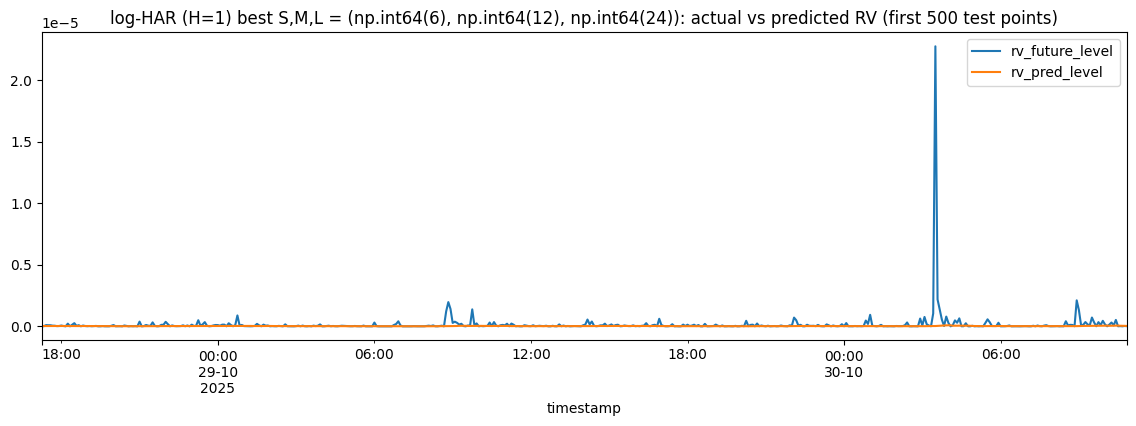

In [31]:
import numpy as np
import matplotlib.pyplot as plt

S_best, M_best, L_best = best_key
res_best = best_result

df_har_best = res_best["df_har"]
split_idx = res_best["split_idx"]

df_eval = df_har_best.iloc[split_idx:].copy()
df_eval["rv_future_level"] = np.exp(df_eval["log_rv_future"])
df_eval["rv_pred_level"] = res_best["y_pred_test_level"].values

N = 500  # 처음 N개만 보기

plt.figure(figsize=(14, 4))
df_eval[["rv_future_level", "rv_pred_level"]].iloc[:N].plot(ax=plt.gca())
plt.title(f"log-HAR (H=1) best S,M,L = {best_key}: actual vs predicted RV (first {N} test points)")
plt.xlabel("timestamp")
plt.show()


In [32]:
import matplotlib.pyplot as plt

def plot_sml_performance(summary_df, param="S"):
    """
    summary_df: grid_search_log_har_sml 에서 나온 summary_df
                index: (S,M,L)
    param: "S", "M", "L" 중 하나

    각 param 값별로
    - R2_train: 최대값 (가장 잘 나왔을 때)
    - MAE_test_level: 최소값 (가장 적게 틀렸을 때)
    을 기준으로 시각화.
    """
    if param not in ("S", "M", "L"):
        raise ValueError("param은 'S', 'M', 'L' 중 하나여야 합니다.")

    df = summary_df.reset_index()

    # param 값별로 "가장 좋은" 성능 집계
    #   R²는 클수록 좋으니까 max
    #   MAE는 작을수록 좋으니까 min
    r2_by_param = df.groupby(param)["R2_train"].max()
    mae_by_param = df.groupby(param)["MAE_test_level"].min()

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # 1) R² vs param
    r2_by_param.plot(marker="o", ax=axes[0])
    axes[0].set_title(f"Train R² vs {param}")
    axes[0].set_xlabel(param)
    axes[0].set_ylabel("R²")
    axes[0].grid(True)

    # 2) MAE(level RV) vs param
    mae_by_param.plot(marker="o", ax=axes[1])
    axes[1].set_title(f"Test MAE (level RV) vs {param}")
    axes[1].set_xlabel(param)
    axes[1].set_ylabel("MAE of RV")
    axes[1].grid(True)

    fig.suptitle(f"log-HAR performance by {param}", y=1.05)
    plt.tight_layout()
    plt.show()


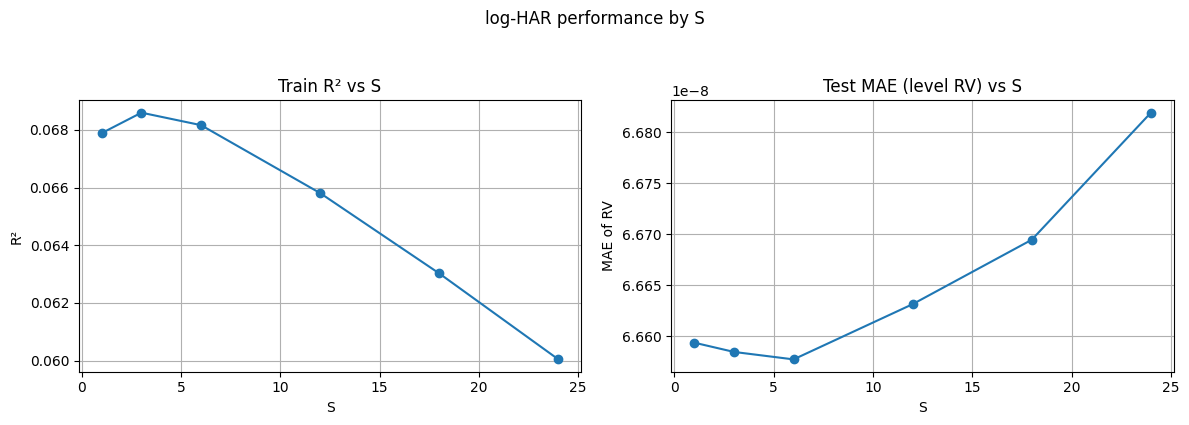

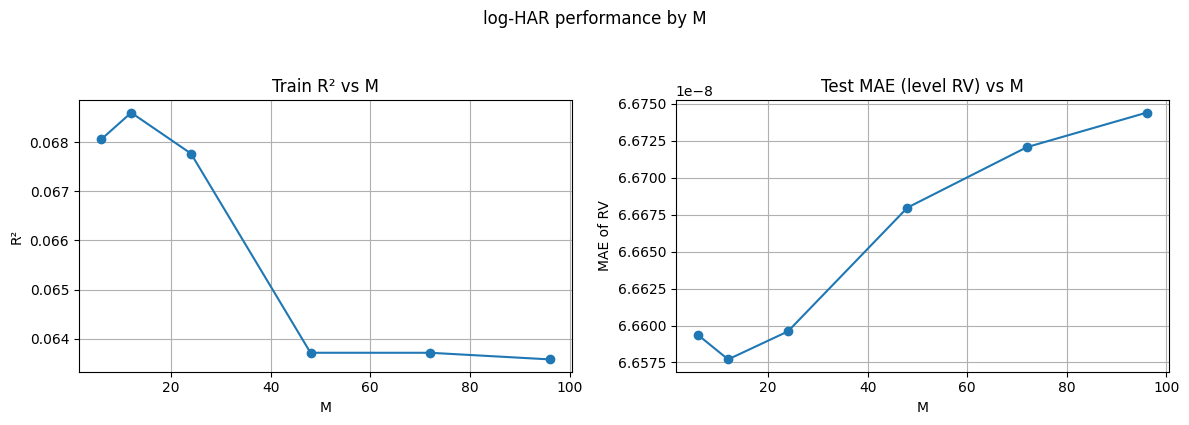

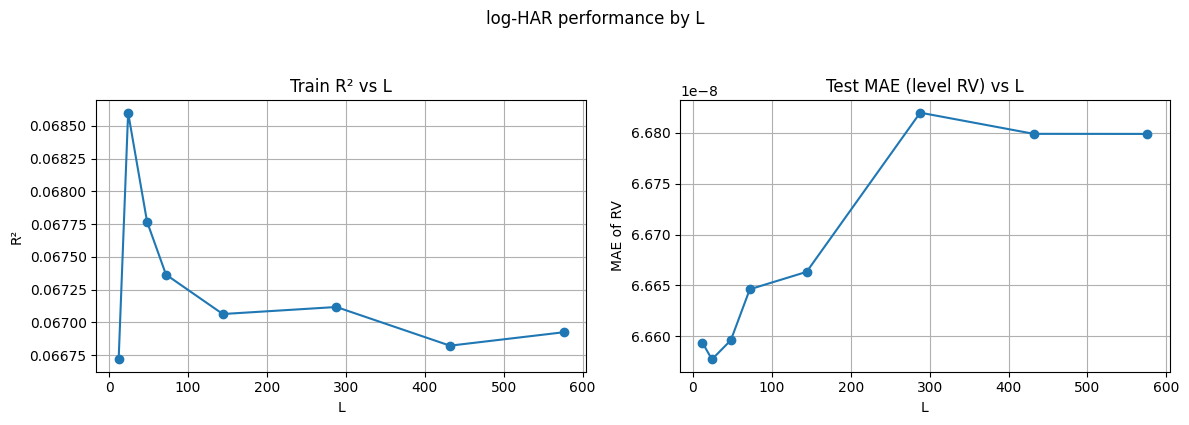

In [33]:
# S에 대한 성능 곡선
plot_sml_performance(summary_df, param="S")

# M에 대한 성능 곡선
plot_sml_performance(summary_df, param="M")

# L에 대한 성능 곡선
plot_sml_performance(summary_df, param="L")
